In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import librosa
import librosa.display
from IPython.display import Audio

import pandas as pd

import os

In [2]:
path_ds = '/home/edoardobucheli/Datasets/freesound-audio-tagging-2019/'
path_train_curated = os.path.join(path_ds,'train_curated')

In [3]:
df_train = pd.read_csv(os.path.join(path_ds,'train_curated.csv'))

In [4]:
df_train[:10]

,fname,labels
0,0006ae4e.wav,Bark
1,0019ef41.wav,Raindrop
2,001ec0ad.wav,Finger_snapping
3,0026c7cb.wav,Run
4,0026f116.wav,Finger_snapping
5,003be5db.wav,Whispering
6,0041de6b.wav,"Acoustic_guitar,Strum"
7,004ca909.wav,Hi-hat
8,00713ec2.wav,Bass_drum
9,0073825a.wav,"Crowd,Cheering"


In [5]:
names = df_train['fname'].tolist()
names_paths = [os.path.join(path_train_curated,f) for f in names]

In [6]:
def log10(x):
    numerator = tf.log(x)
    denominator = tf.log(tf.constant(10, dtype=numerator.dtype))
    return numerator / denominator

In [13]:
def preprocess_wave(file):
    
    twenty = tf.constant(20,dtype = tf.float32)
    zero = tf.constant(0,dtype = tf.float32)
    rate = tf.constant(44100, dtype = tf.int32)
    one = tf.constant(1,dtype = tf.int32)
    
    wave,rate = tf.audio.decode_wav(file, desired_channels = 1, desired_samples = 44100)
    size = tf.shape(wave)[1]
        
    max_start = tf.cond(size <= rate, lambda: one, lambda: size-rate)
        
    start = tf.random_uniform((), minval=0, maxval=max_start, dtype=tf.int32, seed=None, name=None)
    
    x = wave[start:start+44100]
    x = tf.expand_dims(x,axis = 0)
    x = tf.squeeze(x,axis = -1)
    x = x/tf.reduce_max(tf.abs(x),axis = 1)
    
    X = tf.signal.stft(x,frame_length=512, frame_step = 256, fft_length = 1024)
    mX = twenty*log10(tf.abs(X))
    pX = tf.angle(X)
    
    return x,mX,pX

In [14]:
def load_and_preprocess_wav(path):
    file = tf.read_file(path)
    return preprocess_wave(file)

In [15]:
wave_path_ds = tf.data.Dataset.from_tensor_slices(names_paths)

In [16]:
wave_ds = wave_path_ds.map(load_and_preprocess_wav)
wave_ds = wave_ds.batch(16)

In [17]:
wave_ds

<DatasetV1Adapter shapes: ((?, 1, ?), (?, 1, ?, 513), (?, 1, ?, 513)), types: (tf.float32, tf.float32, tf.float32)>

In [18]:
iterator = wave_ds.make_initializable_iterator()
next_element = iterator.get_next()

W0822 12:19:34.720487 139875262048064 deprecation.py:323] From <ipython-input-18-df57af94612c>:1: DatasetV1.make_initializable_iterator (from tensorflow.python.data.ops.dataset_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_initializable_iterator(dataset)`.


In [19]:
sess = tf.Session()

In [20]:
sess.run(iterator.initializer)

In [21]:
this_wave = sess.run(next_element)

InvalidArgumentError: Cannot add tensor to the batch: number of elements does not match. Shapes are: [tensor]: [1,36750], [batch]: [1,44100]
	 [[node IteratorGetNext (defined at <ipython-input-18-df57af94612c>:2) ]]

Errors may have originated from an input operation.
Input Source operations connected to node IteratorGetNext:
 IteratorV2 (defined at <ipython-input-18-df57af94612c>:1)

Original stack trace for 'IteratorGetNext':
  File "/home/edoardobucheli/anaconda3/envs/tf1_14/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/edoardobucheli/anaconda3/envs/tf1_14/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/edoardobucheli/anaconda3/envs/tf1_14/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/edoardobucheli/anaconda3/envs/tf1_14/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/edoardobucheli/anaconda3/envs/tf1_14/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()
  File "/home/edoardobucheli/anaconda3/envs/tf1_14/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/home/edoardobucheli/anaconda3/envs/tf1_14/lib/python3.6/asyncio/base_events.py", line 438, in run_forever
    self._run_once()
  File "/home/edoardobucheli/anaconda3/envs/tf1_14/lib/python3.6/asyncio/base_events.py", line 1451, in _run_once
    handle._run()
  File "/home/edoardobucheli/anaconda3/envs/tf1_14/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/home/edoardobucheli/anaconda3/envs/tf1_14/lib/python3.6/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/edoardobucheli/anaconda3/envs/tf1_14/lib/python3.6/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/home/edoardobucheli/anaconda3/envs/tf1_14/lib/python3.6/site-packages/tornado/gen.py", line 787, in inner
    self.run()
  File "/home/edoardobucheli/anaconda3/envs/tf1_14/lib/python3.6/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/edoardobucheli/anaconda3/envs/tf1_14/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/edoardobucheli/anaconda3/envs/tf1_14/lib/python3.6/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/edoardobucheli/anaconda3/envs/tf1_14/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 272, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/edoardobucheli/anaconda3/envs/tf1_14/lib/python3.6/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/edoardobucheli/anaconda3/envs/tf1_14/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 542, in execute_request
    user_expressions, allow_stdin,
  File "/home/edoardobucheli/anaconda3/envs/tf1_14/lib/python3.6/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/edoardobucheli/anaconda3/envs/tf1_14/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/edoardobucheli/anaconda3/envs/tf1_14/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/edoardobucheli/anaconda3/envs/tf1_14/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2854, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/edoardobucheli/anaconda3/envs/tf1_14/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2880, in _run_cell
    return runner(coro)
  File "/home/edoardobucheli/anaconda3/envs/tf1_14/lib/python3.6/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/home/edoardobucheli/anaconda3/envs/tf1_14/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3057, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/edoardobucheli/anaconda3/envs/tf1_14/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3248, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/home/edoardobucheli/anaconda3/envs/tf1_14/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3325, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-18-df57af94612c>", line 2, in <module>
    next_element = iterator.get_next()
  File "/home/edoardobucheli/anaconda3/envs/tf1_14/lib/python3.6/site-packages/tensorflow/python/data/ops/iterator_ops.py", line 426, in get_next
    output_shapes=self._structure._flat_shapes, name=name)
  File "/home/edoardobucheli/anaconda3/envs/tf1_14/lib/python3.6/site-packages/tensorflow/python/ops/gen_dataset_ops.py", line 1947, in iterator_get_next
    output_shapes=output_shapes, name=name)
  File "/home/edoardobucheli/anaconda3/envs/tf1_14/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 788, in _apply_op_helper
    op_def=op_def)
  File "/home/edoardobucheli/anaconda3/envs/tf1_14/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "/home/edoardobucheli/anaconda3/envs/tf1_14/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3616, in create_op
    op_def=op_def)
  File "/home/edoardobucheli/anaconda3/envs/tf1_14/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2005, in __init__
    self._traceback = tf_stack.extract_stack()


In [17]:
this_wave[0].shape

AttributeError: 'bytes' object has no attribute 'shape'

In [387]:
sr = 44100

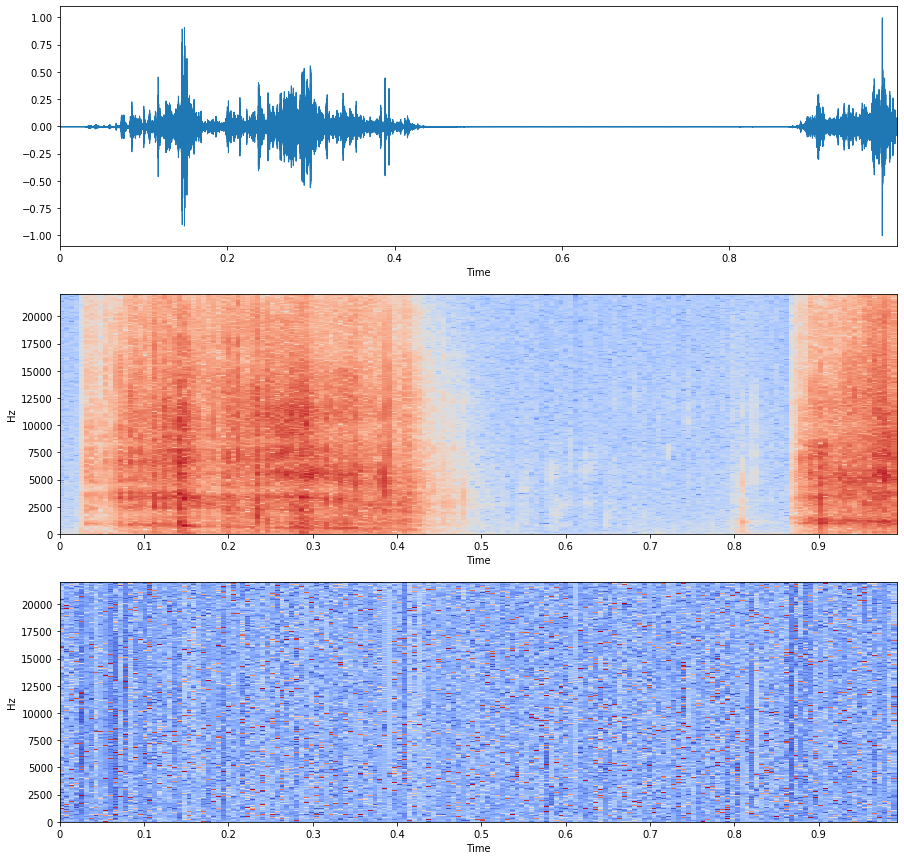

In [388]:
#n = np.random.randint(0,1)
#print(n)
plt.figure(figsize = (15,15))
plt.subplot(3,1,1)
librosa.display.waveplot(this_wave.squeeze(0),sr = sr)
plt.subplot(3,1,2)
librosa.display.specshow(this_mSpec.squeeze(0).T,x_axis='time',y_axis='linear',sr=sr,hop_length=256)
plt.subplot(3,1,3)
librosa.display.specshow(np.diff(np.unwrap(this_pSpec.squeeze(0),axis=1),axis=1).T,x_axis='time',y_axis='linear',sr=sr,hop_length=256)

In [389]:
Audio(this_wave.squeeze(0),rate = sr)